In this file we will tune and build machine learning models from the features selected in feature_selection.ipynb

**Importing libraries**

In [2]:
import random
import os
import numpy as np
# had to uses pip to install librosa
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from scikitplot.metrics import plot_confusion_matrix 
from scipy.io import wavfile as wav
from librosa.feature import melspectrogram
import pickle
from tqdm import tqdm
import inspect
import pandas as pd
import re

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, SGDClassifier, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split

Setting path variable:

In [2]:
path = os.getcwd() + '\\data\\'
print(path)

c:\Users\Emili\DSIM_project\ID\data\


## **Loading data**

In [3]:
# Data loader
def load_data(feature_extractor, train_size):
  
  # Note: train size must be the same as in load_data_features that was used in feature_selection.ipynb

  X_train = []
  y_train = []

  X_test = []
  y_test = []

  random.seed(10) # For reproducibility

  random.shuffle(os.listdir(path))
  for speaker in os.listdir(path):
    tracks = os.listdir(path + speaker)
    random.shuffle(tracks) # We don't want the first seconds to systematically
                           # be train and the last to be test
    track_num = 0
    for track in tracks:
      track_num = track_num + 1
      _, signal = wav.read(path + speaker + '/' + track)

      if track_num <=np.floor(train_size*len(tracks)):
        X_train.append(feature_extractor(signal))
        y_train.append(speaker)
      else:
        X_test.append(feature_extractor(signal))
        y_test.append(speaker)
                
  eps = 0.001
  X_train = np.array(X_train)
  X_train_mean = X_train.mean(axis=0)
  X_train_std = X_train.std(axis=0)
  X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
  X_train = [row for row in X_train]
  X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

  return X_train, X_test, y_train, y_test

def feats_melspec(input, rate = 8000):
  input = melspectrogram(y = input*1.0, sr = rate)
  output = input.flatten()
  return output

def zcr (input):
  k=0
  for i in range(0, len(input)-1):
    if input[i]*input[i+1]<0:
      k=k+1

  return np.array(k, ndmin = 1)

def standard_dev(input):
    return np.std(input, keepdims=True)
  
def energy(input):
    return np.sum((input*1.0)**2, keepdims=True)
  
def combo(input):
  return np.concatenate((standard_dev(input),energy(input), zcr(input), feats_melspec(input)))

In [4]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo, train_size=0.8)

Saving datasets as pickle files in case we want to re-run stuff without having to load the data again with the previous function

In [5]:
def save_as_pickle(file, path):
  with open(path, "wb") as fp:
    pickle.dump(file, fp)
    
if not os.path.isdir(os.getcwd() + '\\train_test_data'):
  os.mkdir(os.getcwd() + '\\train_test_data')

names = ['X_train', 'X_test', 'y_train', 'y_test']
i = 0
for file in [X_train, X_test, y_train, y_test]:
  save_as_pickle(file, os.getcwd() + '\\train_test_data\\' + names[i] + '.pkl')
  i = i + 1

This is how they're loaded from the pickle files:

In [3]:
with open(os.getcwd() + '\\train_test_data\\X_train.pkl', "rb") as fp:   # Unpickling
    X_train = pickle.load(fp)
with open(os.getcwd() + '\\train_test_data\\y_train.pkl', "rb") as fp:   # Unpickling
    y_train = pickle.load(fp)
with open(os.getcwd() + '\\train_test_data\\X_test.pkl', "rb") as fp:   # Unpickling
    X_test = pickle.load(fp)
with open(os.getcwd() + '\\train_test_data\\y_test.pkl', "rb") as fp:   # Unpickling
    y_test = pickle.load(fp)

## **Validation on classifier models**
We decided to try a few classifiers in the skleqrn library to see which one would be the best for our data. We will use the validation set to see which one is the best and keep the default hyperparameters for now.

In [7]:
def try_classifiers(X, Y, classifiers, dest_path, random_state, split):
    
    train_test_acc = {}
    
    # Splitting the set for validation
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = split, random_state = random_state)



    for classifier in tqdm(classifiers):
        
        if classifier.__name__ == 'XGBClassifier':
            print('data format changed\n')
            X_train = pd.DataFrame(np.row_stack(X_train))
            X_val = pd.DataFrame(np.row_stack(X_val))
            Y_train = pd.DataFrame(np.row_stack(Y_train))
            for i in range(len(Y_train.loc[:,0])):
                m = re.search(r'\d+$', Y_train.loc[i,0])
                Y_train.loc[i,0] = int(m.group())-1
            Y_train = Y_train.astype('str').astype('int')
            Y_val = pd.DataFrame(np.row_stack(Y_val))
            for i in range(len(Y_val.loc[:,0])):
                m = re.search(r'\d+$', Y_val.loc[i,0])
                Y_val.loc[i,0] = int(m.group())-1
            Y_val = Y_val.astype('str').astype('int')

        print('Training', classifier.__name__)

        # If classifier has random_state parameter, set it to random_state
        if 'random_state' in inspect.signature(classifier).parameters:
            estimator = classifier(random_state = random_state)
        else:
            estimator = classifier()
    
        estimator.fit(X_train, Y_train)       
    
        train_acc = estimator.score(X_train, Y_train)
        test_acc = estimator.score(X_val, Y_val)

        train_test_acc[classifier.__name__] = [train_acc, test_acc]

    perf_df = pd.DataFrame.from_dict(train_test_acc, orient = 'index',
                                     columns = ['train2 acc', 'val_acc'])

    perf_df = perf_df.sort_values(by = ['val_acc'], ascending = False)
    

    perf_df.to_csv(dest_path, index = True) # Needs to be opened with index_col = 0

    
    return 'Performances saved successfully'

In [8]:
classifiers = [LogisticRegression, RidgeClassifier, GaussianNB,
               LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis, RandomForestClassifier,
               KNeighborsClassifier, NearestCentroid, XGBClassifier]
dest_path = os.getcwd() + '\\classifiers_summary.csv'
random_state = 10

print('Trying out different classifiers')
print(try_classifiers(X_train, y_train, classifiers, dest_path, random_state, 0.3))

Trying out different classifiers


  0%|          | 0/9 [00:00<?, ?it/s]

Training LogisticRegression


c:\Users\Emili\miniconda3\envs\DSIM\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 11%|█         | 1/9 [00:54<07:12, 54.07s/it]

Training RidgeClassifier


 22%|██▏       | 2/9 [01:04<03:17, 28.21s/it]

Training GaussianNB


 33%|███▎      | 3/9 [01:32<02:50, 28.36s/it]

Training LinearDiscriminantAnalysis


 44%|████▍     | 4/9 [05:39<09:31, 114.40s/it]

Training QuadraticDiscriminantAnalysis


c:\Users\Emili\miniconda3\envs\DSIM\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
 56%|█████▌    | 5/9 [06:30<06:06, 91.54s/it] 

Training RandomForestClassifier


 67%|██████▋   | 6/9 [08:18<04:51, 97.20s/it]

Training KNeighborsClassifier


 78%|███████▊  | 7/9 [08:32<02:20, 70.03s/it]

Training NearestCentroid


 89%|████████▉ | 8/9 [08:33<00:48, 48.20s/it]

data format changed

Training XGBClassifier


100%|██████████| 9/9 [1:07:35<00:00, 450.59s/it] 

Performances saved successfully


In [9]:
pd.read_csv(dest_path, index_col = 0)

,train2 acc,val_acc
XGBClassifier,0.999812,0.893187
RandomForestClassifier,0.999812,0.871648
LogisticRegression,0.999812,0.837802
NearestCentroid,0.853806,0.771429
GaussianNB,0.982668,0.745055
RidgeClassifier,0.999812,0.343297
KNeighborsClassifier,0.195177,0.096703
LinearDiscriminantAnalysis,0.999812,0.088352
QuadraticDiscriminantAnalysis,0.999812,0.034725


We are going to try the following classifiers:
- **Random Forest** (second best validation accuracy with less computational time than XGBoost)
- **NearestCentroid** (least overfitting while mantaining a decent validation accuracy)

## **Random Forest**

### **Hyperparameter tuning**

We will tune the hyperparameters of the random forest model by using a custom made function that doesn't use cross validation (it uses a single split instead) to save computational time. We will use the following hyperparameters:


- 'n_estimators': [50, 100, 200, 500],
- 'max_features': [ 'sqrt', 'log2'],
- 'min_samples_leaf': [2, 5, 10, 20],
- 'criterion' :['gini', 'entropy']


In [102]:
def rf_tuning(X, Y, hyperparameters, dest_path, random_state, split):
    
    train_test_acc = {}
    
    # Splitting the set for validation
    X_train2, X_val, Y_train2, Y_val = train_test_split(X, Y, test_size = split, random_state = random_state)

    train_test_acc = {}

    for n in hyperparameters['n_estimators']:
        for f in hyperparameters['max_features']:
            for l in hyperparameters['min_samples_leaf']:
                for c in hyperparameters['criterion']:
                    clf = RandomForestClassifier(n_estimators=n, max_features=f, min_samples_leaf=l, criterion=c)
                    clf.fit(X_train2, Y_train2)
                    train2_acc = clf.score(X_train2, Y_train2)
                    val_acc = clf.score(X_val, Y_val)
                    
                    hp_combo = {'n_estimators':  n, 'max_features': f, 'min_samples_leaf': l, 'criterion': c}
                    key = str(hp_combo)
                    train_test_acc[key] = [train2_acc, val_acc]
                    
    perf_df = pd.DataFrame.from_dict(train_test_acc, orient = 'index',
                                     columns = ['train2 acc', 'val_acc'])
        
    perf_df = perf_df.sort_values(by = ['val_acc'], ascending = False)
    

    perf_df.to_csv(dest_path, index = True) # Needs to be opened with index_col = 0

    
    return 'Performances saved successfully'

In [1]:
dest_path = os.getcwd() + '\\RF_tuning.csv'
hyperparameters = {
    'n_estimators': [50, 100, 200, 500],
    'max_features': [ 'sqrt', 'log2'],
    'min_samples_leaf': [2, 5, 10, 20],
    'criterion' :['gini', 'entropy']
}
random_state = 10
split = 0.3
X = X_train
Y = y_train

print(rf_tuning(X, Y, hyperparameters, dest_path, random_state, split))

rf_tuning_df = pd.read_csv(dest_path, index_col = 0)

NameError: name 'X_train' is not defined

In [162]:
rf_tuning_df.head(10)

,train2 acc,val_acc
"{'n_estimators': 500, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'criterion': 'gini'}",0.999246,0.919121
"{'n_estimators': 500, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'criterion': 'gini'}",0.999812,0.912967
"{'n_estimators': 500, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'criterion': 'entropy'}",0.999812,0.907692
"{'n_estimators': 500, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'criterion': 'gini'}",0.998681,0.907253
"{'n_estimators': 500, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'criterion': 'entropy'}",0.998116,0.906813
"{'n_estimators': 200, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'criterion': 'gini'}",0.999812,0.904615
"{'n_estimators': 500, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'criterion': 'gini'}",0.996044,0.904176
"{'n_estimators': 500, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'criterion': 'entropy'}",0.999435,0.904176
"{'n_estimators': 200, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'criterion': 'gini'}",0.999058,0.904176
"{'n_estimators': 200, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'criterion': 'gini'}",0.998493,0.902418


### **Final model**
Fitting model with optimal parameters:

In [10]:
rf = RandomForestClassifier(n_estimators=500, criterion='gini', max_features='sqrt',
                            min_samples_leaf=5, random_state=10)
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=5, n_estimators=500, random_state=10)

**Performances:**

In [11]:
print(f"\nAccuracy on train set: {rf.score(X_train, y_train)}")


Accuracy on train set: 0.9994725042859027


In [12]:
predictions = rf.predict(X_test)

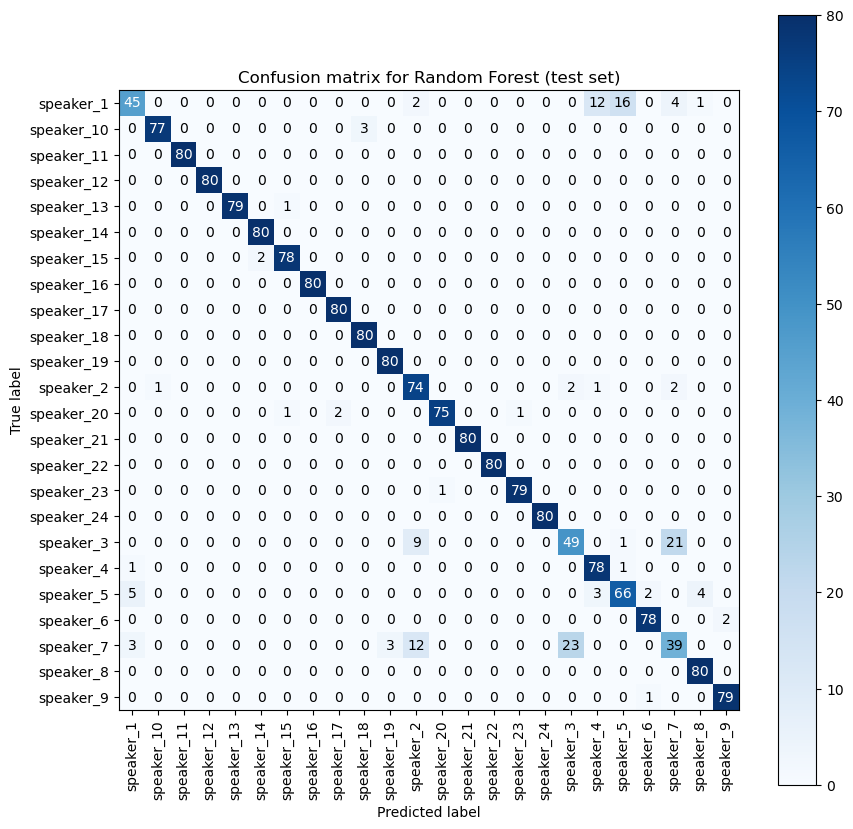

In [8]:
plot_confusion_matrix(y_test, predictions, x_tick_rotation=90, figsize=(10,10),
                      title='Confusion matrix for Random Forest (test set)');

In [13]:
def get_classification_report(y_test, y_pred):

    report = classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    df_classification_report = df_classification_report.round(3)
    df_classification_report = df_classification_report.drop(['weighted avg'])
    df_classification_report['support'] = df_classification_report['support'].astype(int)
    df_classification_report['accuracy'] = np.nan
    df_classification_report = df_classification_report[['accuracy', 'precision', 'recall', 'f1-score', 'support']]
    df_classification_report['accuracy']['macro avg']= df_classification_report['precision']['accuracy']
    df_classification_report = df_classification_report.drop(['accuracy'], axis=0)
    df_classification_report.rename({'macro avg': 'average'}, axis=0, inplace=True)
    return df_classification_report

In [14]:
classification_report_df = get_classification_report(y_test, predictions)
print('\nClassification report for Random Forest (test set):')
classification_report_df


Classification report for Random Forest (test set):


,accuracy,precision,recall,f1-score,support
speaker_1,NaN,0.833,0.562,0.672,80
speaker_10,NaN,0.987,0.962,0.975,80
speaker_11,NaN,1.000,1.000,1.000,80
speaker_12,NaN,1.000,1.000,1.000,80
speaker_13,NaN,1.000,0.988,0.994,80
speaker_14,NaN,0.976,1.000,0.988,80
speaker_15,NaN,0.975,0.975,0.975,80
speaker_16,NaN,1.000,1.000,1.000,80
speaker_17,NaN,0.976,1.000,0.988,80
speaker_18,NaN,0.964,1.000,0.982,80


In [11]:
classification_report_df.to_csv(os.getcwd() + '\\RF_performances.csv', index = True)
# Has to be read with index_col = 0

In [12]:
pickle.dump(rf, open(os.getcwd() + '\\RF.sav', 'wb'))

As we can see even though the model is overfitting a bit, it is still performing well on the test set.
If we look at the F1 score of each class, the only bad performing users are **speaker_1**, **speaker_3** and **speaker_7**. who still achieve a score higher than 0.5. Not bad considering we have 24 classes

## **Nearest Centroid**

### **Hyperparameter tuning**

We will use the following hyperparameters:


- 'metrics': ['euclidean', 'manhattan'],
- 'shrink_threshold': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

Since this model doesn't have many hyperparameters and is computationally cheap, we will use cross validation to tune the hyperparameters

In [15]:
hyperparameters = {'metric': ['euclidean', 'manhattan'],
                   'shrink_threshold': [0, 0.1, 0.2, 0.3, 0.4, 0.5,
                                        0.6, 0.7, 0.8, 0.9, 1.0]}

In [ ]:
nc = NearestCentroid()
clf = GridSearchCV(nc, hyperparameters, n_jobs=-1, cv=5, verbose=1)
clf.fit(X_train, y_train)

In [198]:
clf.best_params_

{'metric': 'euclidean', 'shrink_threshold': None}

The best hyperparameters are the default ones

### **Final model**
Fitting model with optimal parameters:

In [15]:
nc = NearestCentroid()
nc.fit(X_train, y_train)

NearestCentroid()

**Performances:**

In [16]:
print(f"\nAccuracy on train set: {nc.score(X_train, y_train)}")


Accuracy on train set: 0.8519055782671766


In [17]:
predictions = nc.predict(X_test)

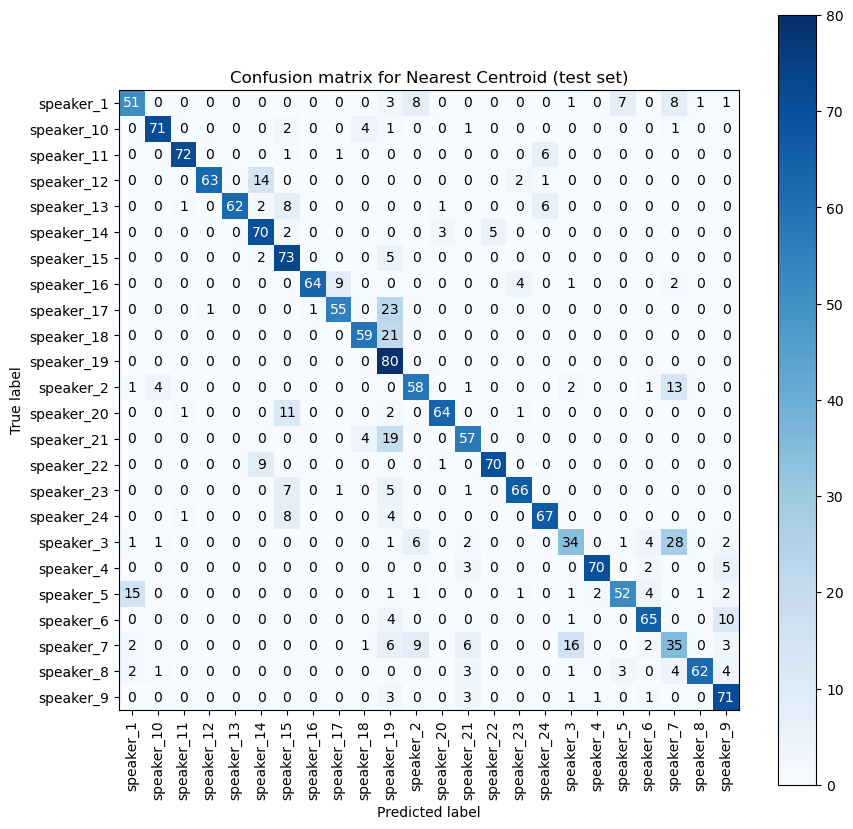

In [16]:
plot_confusion_matrix(y_test, predictions, x_tick_rotation=90, figsize=(10,10),
                      title='Confusion matrix for Nearest Centroid (test set)');

In [17]:
classification_report_df = get_classification_report(y_test, predictions)
print('\nClassification report for Nearest Centroid (test set):')

classification_report_df


Classification report for Nearest Centroid (test set):


,accuracy,precision,recall,f1-score,support
speaker_1,NaN,0.708,0.638,0.671,80
speaker_10,NaN,0.922,0.888,0.904,80
speaker_11,NaN,0.960,0.900,0.929,80
speaker_12,NaN,0.984,0.788,0.875,80
speaker_13,NaN,1.000,0.775,0.873,80
speaker_14,NaN,0.722,0.875,0.791,80
speaker_15,NaN,0.652,0.912,0.760,80
speaker_16,NaN,0.985,0.800,0.883,80
speaker_17,NaN,0.833,0.688,0.753,80
speaker_18,NaN,0.868,0.738,0.797,80


In [18]:
classification_report_df.to_csv(os.getcwd() + '\\NC_performances.csv', index = True)
# Has to be read with index_col = 0

In [19]:
pickle.dump(nc, open(os.getcwd() + '\\NC.sav', 'wb'))

Since the model is computationally cheap, we can also try a **5-fold cross validation**  on the whole dataset (instead of a train-teest single split) to check accuracy:

In [206]:
def load_data_cv(feature_extractor, k_folds):

  X= [[] for i in range(k_folds)]
  y= [[] for i in range(k_folds)]
  
  output = []

  random.seed(10) # For reproducibility

  random.shuffle(os.listdir(path))
  for speaker in os.listdir(path):
    tracks = os.listdir(path + speaker)
    random.shuffle(tracks) # We don't want the first seconds to systematically
                           # be train and the last to be test
                           
                           
    split = int(len(tracks)//k_folds)
    k_splits = [split*i for i in range(k_folds)]
    k_splits = k_splits + [len(tracks)]
    track_num = 0
    for track in tracks:
      
      _, signal = wav.read(path + speaker + '/' + track)

      for j in range(k_folds):
        if track_num in range(k_splits[j],k_splits[j+1]):
          X[j].append(feature_extractor(signal))
          y[j].append(speaker)
          
      track_num = track_num + 1
          
  eps = 0.001
  
  for j in range(k_folds):
    
    # Normalizing  input
    X_test = np.array(X[j])
    X_train_list_of_lists = [X[h] for h in range(k_folds) if h!=j]
    X_train = np.array([item for sublist in X_train_list_of_lists for item in sublist])
    X_train_mean = X_train.mean(axis=0)
    X_train_std = X_train.std(axis=0)
    X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
    X_train = [row for row in X_train]
    X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]
    
    y_test = np.array(y[j])
    y_train_list_of_lists = [y[h] for h in range(k_folds) if h!=j]
    y_train = [item for sublist in y_train_list_of_lists for item in sublist]
    
    print(j, '-th split', len(X_train), len(X_test), '\n\n')
    
    output.append([X_train, X_test, y_train, y_test])


  return output

In [208]:
k_folds = 5

cv_data = load_data_cv(combo, k_folds)

print('Loading completed')

train_acc = 0
test_acc = 0

for i in range(k_folds):

    model = NearestCentroid()
    model.fit(cv_data[i][0], cv_data[i][2])

    predictions = model.predict(cv_data[i][1])

    train_acc = train_acc + model.score(cv_data[i][0], cv_data[i][2])


    test_acc = test_acc + model.score(cv_data[i][1], cv_data[i][3])
    

print(f"\nAccuracy on train set: {train_acc/k_folds}")
print(f"\nAccuracy on test set: {test_acc/k_folds}")

Loading completed

Accuracy on train set: 0.8498487263328146

Accuracy on test set: 0.7824830115946725


The results are slighlty better than the ones achieved with a single split (train accuracy is about 1% lower and test accuracy is about 1% higher)